# CNN for Rock Paper Scissors Dataset

Goal: Obtain 90% test accuracy on the rock paper scissors dataset.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tf.random.set_seed(42) # Set random seed for reproducibility

The dataset is only partitioned into training and test sets, so we set aside 30% of the training set as a validation set.

In [3]:
(ds_train, ds_val, ds_test) = tfds.load(
    'rock_paper_scissors',
    split=['train[:70%]','train[70%:]','test'],
    shuffle_files=True,
    as_supervised=True
)

Next, we normalize by dividing by 255 and resize the images to 128x128. We also shuffle the training data to ensure that the model doesn't learn its order, and batch the training, validation, and test data.

In [4]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize images
    image = tf.image.resize(image, [128, 128])  # Resize images
    return image, label

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

ds_train = ds_train.map(preprocess).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE) # shuffle so the model doesn't learn the order of the training data
ds_val = ds_val.map(preprocess).batch(BATCH_SIZE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE)

We start with a simple network with one comvolutional layer with 32 filters and a 3x3 kernel.

In [5]:
input_shape = (128, 128, 3)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(16, (3, 3), activation='relu'),  # Convolution step
    layers.MaxPooling2D((2, 2)),  # Pooling step
    layers.Flatten(),  # Flattening for classification
    layers.Dense(128, activation='relu'), # Dense layer before final classification layer
    layers.Dense(3)  # 3 classes
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

Before fitting our model, we add an early stop mechanism to prevent overfitting.

In [6]:
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

In [7]:
history = model.fit(ds_train, epochs=10, validation_data=(ds_val), callbacks=[early_stop])

Epoch 1/10
56/56 [==============================] - 15s 91ms/step - loss: 2.0504 - accuracy: 0.6043 - val_loss: 0.5658 - val_accuracy: 0.7553
Epoch 2/10
56/56 [==============================] - 4s 38ms/step - loss: 0.3220 - accuracy: 0.9484 - val_loss: 0.1892 - val_accuracy: 0.9643
Epoch 3/10
56/56 [==============================] - 4s 39ms/step - loss: 0.1380 - accuracy: 0.9813 - val_loss: 0.1075 - val_accuracy: 0.9828
Epoch 4/10
56/56 [==============================] - 4s 37ms/step - loss: 0.0633 - accuracy: 0.9938 - val_loss: 0.0533 - val_accuracy: 0.9974
Epoch 5/10
56/56 [==============================] - 4s 36ms/step - loss: 0.0340 - accuracy: 0.9994 - val_loss: 0.0427 - val_accuracy: 0.9974
Epoch 6/10
56/56 [==============================] - 4s 50ms/step - loss: 0.0231 - accuracy: 0.9994 - val_loss: 0.0266 - val_accuracy: 0.9974
Epoch 7/10
56/56 [==============================] - 4s 37ms/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.0221 - val_accuracy: 0.9960
Epoch 8/10
5

Training accuracy of 100% and validation accuracy of over 99%? If something seems too good to be true, it probably is. Let's evaluate on the test data.

In [8]:
model.evaluate(ds_test)

12/12 [==============================] - 1s 57ms/step - loss: 1.0086 - accuracy: 0.7043


[1.008601427078247, 0.7043010592460632]

As expected, no such luck. What happens when we add another convolutional layer?

In [9]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(16, (3, 3), activation='relu'),  # First convolution step
    layers.MaxPooling2D((2, 2)),  # First pooling step
    layers.Conv2D(32, (3, 3), activation='relu'),  # Second convolution step
    layers.MaxPooling2D((2, 2)),  # Second pooling step
    layers.Flatten(),  # Flattening for classification
    layers.Dense(128, activation='relu'), # Dense layer before final classification layer
    layers.Dense(3)  # 3 classes
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
history = model.fit(ds_train, epochs=10, validation_data=(ds_val),callbacks=[early_stop])

Epoch 1/10
56/56 [==============================] - 6s 50ms/step - loss: 0.7759 - accuracy: 0.7177 - val_loss: 0.1547 - val_accuracy: 0.9828
Epoch 2/10
56/56 [==============================] - 4s 40ms/step - loss: 0.0654 - accuracy: 0.9898 - val_loss: 0.0278 - val_accuracy: 0.9987
Epoch 3/10
56/56 [==============================] - 5s 61ms/step - loss: 0.0164 - accuracy: 0.9983 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 4/10
56/56 [==============================] - 4s 38ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 5/10
56/56 [==============================] - 4s 39ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 6/10
56/56 [==============================] - 5s 55ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 7/10
56/56 [==============================] - 4s 38ms/step - loss: 7.7240e-04 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 8/1

In [11]:
model.evaluate(ds_test)

12/12 [==============================] - 0s 15ms/step - loss: 1.1698 - accuracy: 0.7177


[1.1698219776153564, 0.7177419066429138]

An improvement, but still not amazing. Would a third convolutional layer help?

In [12]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(16, (3, 3), activation='relu'),  # First convolution step
    layers.MaxPooling2D((2, 2)),  # First pooling step
    layers.Conv2D(32, (3, 3), activation='relu'),  # Second convolution step
    layers.MaxPooling2D((2, 2)),  # Second pooling step
    layers.Conv2D(64, (3, 3), activation='relu'),  # Third convolution step
    layers.MaxPooling2D((2, 2)),  # Third pooling step
    layers.Flatten(),  # Flattening for classification
    layers.Dense(128, activation='relu'), # Dense layer before final classification layer
    layers.Dense(3)  # 3 classes
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
history = model.fit(ds_train, epochs=10, validation_data=(ds_val),callbacks=[early_stop])

Epoch 1/10
56/56 [==============================] - 7s 43ms/step - loss: 0.4908 - accuracy: 0.7834 - val_loss: 0.0667 - val_accuracy: 0.9921
Epoch 2/10
56/56 [==============================] - 5s 40ms/step - loss: 0.0287 - accuracy: 0.9926 - val_loss: 0.0090 - val_accuracy: 0.9947
Epoch 3/10
56/56 [==============================] - 4s 39ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 4/10
56/56 [==============================] - 4s 44ms/step - loss: 9.3235e-04 - accuracy: 1.0000 - val_loss: 6.8524e-04 - val_accuracy: 1.0000
Epoch 5/10
56/56 [==============================] - 4s 39ms/step - loss: 3.3497e-04 - accuracy: 1.0000 - val_loss: 3.1429e-04 - val_accuracy: 1.0000
Epoch 6/10
56/56 [==============================] - 4s 40ms/step - loss: 1.7841e-04 - accuracy: 1.0000 - val_loss: 3.1386e-04 - val_accuracy: 1.0000
Epoch 6: early stopping


In [14]:
model.evaluate(ds_test)

12/12 [==============================] - 0s 10ms/step - loss: 0.6063 - accuracy: 0.8441


[0.6062671542167664, 0.8440860509872437]

That's better! What about a fourth layer?

In [15]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(16, (3, 3), activation='relu'),  # First convolution step
    layers.MaxPooling2D((2, 2)),  # First pooling step
    layers.Conv2D(32, (3, 3), activation='relu'),  # Second convolution step
    layers.MaxPooling2D((2, 2)),  # Second pooling step
    layers.Conv2D(64, (3, 3), activation='relu'),  # Third convolution step
    layers.MaxPooling2D((2, 2)),  # Third pooling step
    layers.Conv2D(128, (3, 3), activation='relu'),  # Fourth convolution step
    layers.MaxPooling2D((2, 2)),  # Fourth pooling step
    layers.Flatten(),  # Flattening for classification
    layers.Dense(128, activation='relu'), # Dense layer before final classification layer
    layers.Dense(3)  # 3 classes
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
history = model.fit(ds_train, epochs=10, validation_data=(ds_val),callbacks=[early_stop])

Epoch 1/10
56/56 [==============================] - 8s 43ms/step - loss: 0.5981 - accuracy: 0.7432 - val_loss: 0.1793 - val_accuracy: 0.9180
Epoch 2/10
56/56 [==============================] - 4s 38ms/step - loss: 0.0409 - accuracy: 0.9892 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 3/10
56/56 [==============================] - 5s 53ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 4/10
56/56 [==============================] - 4s 40ms/step - loss: 5.9998e-04 - accuracy: 1.0000 - val_loss: 4.3665e-04 - val_accuracy: 1.0000
Epoch 5/10
56/56 [==============================] - 4s 38ms/step - loss: 2.4689e-04 - accuracy: 1.0000 - val_loss: 2.5055e-04 - val_accuracy: 1.0000
Epoch 6/10
56/56 [==============================] - 5s 55ms/step - loss: 1.6089e-04 - accuracy: 1.0000 - val_loss: 1.8180e-04 - val_accuracy: 1.0000
Epoch 7/10
56/56 [==============================] - 4s 40ms/step - loss: 1.1521e-04 - accuracy: 1.0000 - val_loss: 1.2940e-04 - va

In [17]:
model.evaluate(ds_test)

12/12 [==============================] - 0s 21ms/step - loss: 0.3392 - accuracy: 0.9301


[0.33918026089668274, 0.9301075339317322]

We did it! Now we can plot the learning curves for the last model and take a look at test images that were identified correctly and incorrectly.

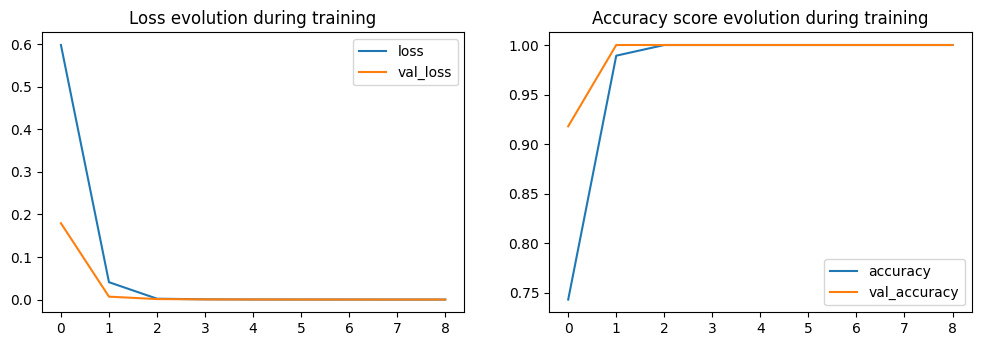

In [18]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss evolution during training')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy score evolution during training')
    plt.legend();

plot_learning_curves(history)

In [19]:
# Make predictions on the test set
test_images, test_labels = [], []
for images, labels in ds_test:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())
test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Identify correct and incorrect predictions
correct_predictions = predicted_labels == test_labels
incorrect_predictions = predicted_labels != test_labels

# Get indices for correct and incorrect predictions
correct_indices = np.where(correct_predictions)[0]
incorrect_indices = np.where(incorrect_predictions)[0]

12/12 [==============================] - 0s 7ms/step


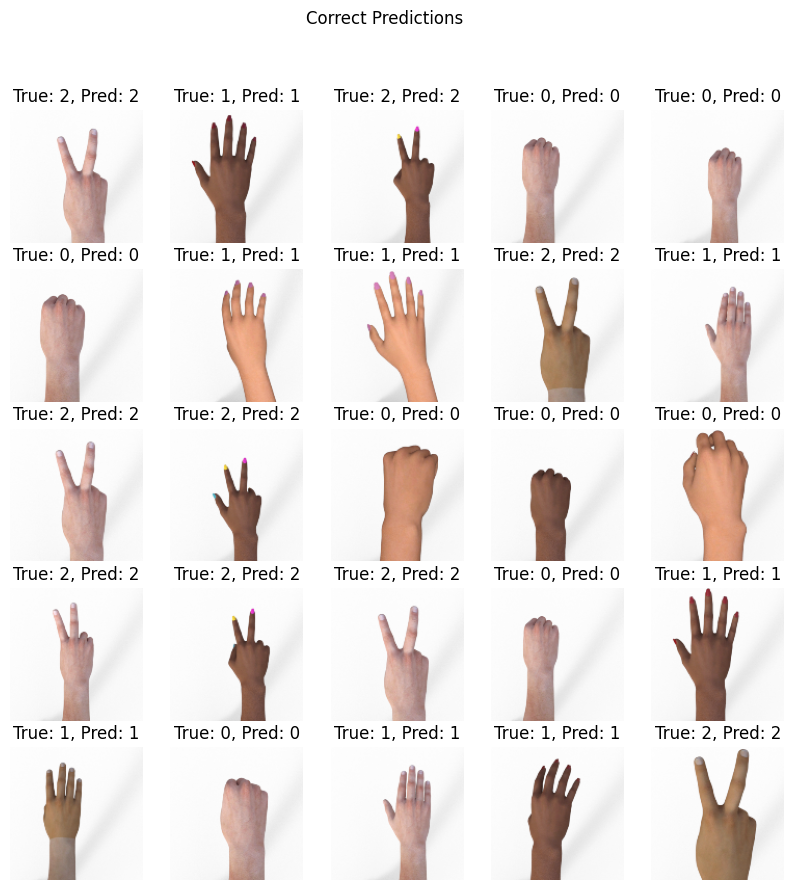

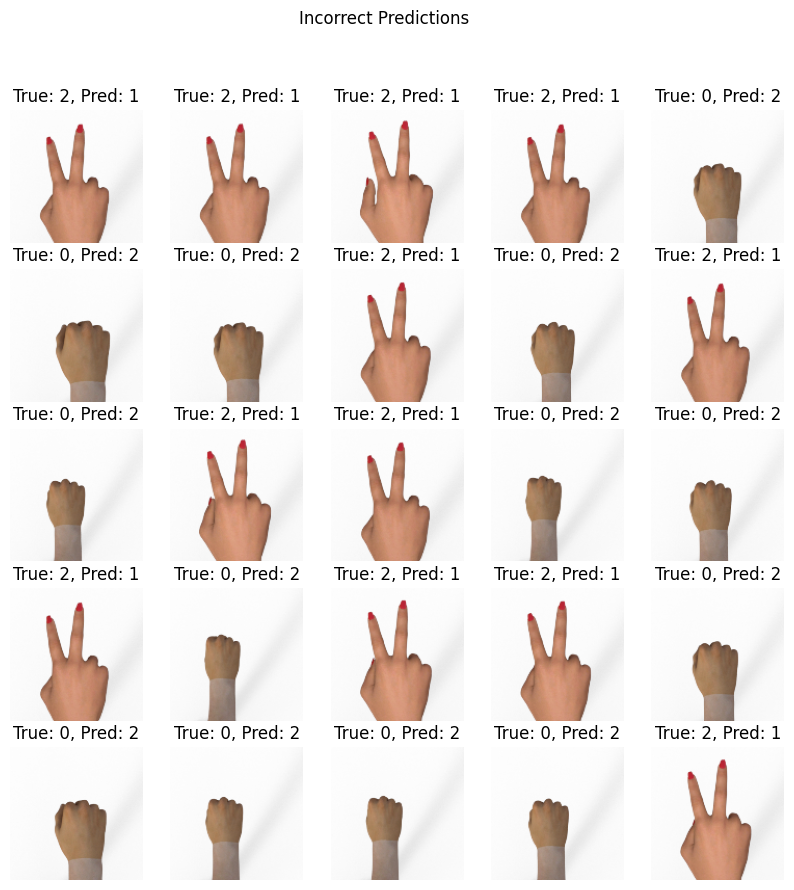

In [20]:
# Function to plot images with their predictions and true labels
def plot_predictions(images, true_labels, predicted_labels, indices, title):
    plt.figure(figsize=(10, 10))
    for i, index in enumerate(indices[:25]):  # Plot the first 25 images
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[index])
        plt.title(f"True: {true_labels[index]}, Pred: {predicted_labels[index]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot correct predictions
plot_predictions(test_images, test_labels, predicted_labels, correct_indices, title="Correct Predictions")

# Plot incorrect predictions
plot_predictions(test_images, test_labels, predicted_labels, incorrect_indices, title="Incorrect Predictions")

What observations can you make about the images that were classified correctly and incorrectly?

Let's save our model weights so we can use the model again later.

In [21]:
model.save_weights('./checkpoints/my_checkpoint')